In [1]:

import matplotlib.pyplot as plt
import numpy as np
import helper

import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import torchmetrics
import timm
import time
import datetime
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size=1
image_count=50
img_size=256
tf = ToTensor()

In [2]:
label_data=pd.read_csv('../../docker/test.csv')
file_list=glob('../../data/frame/test/*')

In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list

        self.label = label_list


    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        image_tensor = torch.empty((image_count,3, img_size, img_size))
        
        image_file_list = glob(self.img_path[idx]+'/*.jpg')
        if len(image_file_list)>image_count:
            count = 0
            for index in range(image_count):
                image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
                image_tensor[count] = image
                count += 1
        else:
            count = 0
            for index in range(len(image_file_list)):
                image = 1-tf(Image.open(image_file_list[index]).resize((img_size,img_size)))
                image_tensor[count] = image
                count += 1
            for i in range(image_count-count):
                image = 1-tf(Image.open(image_file_list[i]).resize((img_size,img_size)))
                image_tensor[count] = image
                count += 1
        label_tensor =  self.label[idx]
        return self.img_path[idx],image_tensor, label_tensor


test_label_list = []
for i in range(len(file_list)):
    label=label_data.loc[label_data['Serial Number']==int(os.path.basename(file_list[i])[:-1])]
    label=label.loc[label_data['wake']==int(os.path.basename(file_list[i])[-1])]
    label=label['label'].item()
    if label=='Oropharynx':
        test_label_list.append(0)
    elif label=='Tonguebase':
        test_label_list.append(1)
    elif label=='Epiglottis':
        test_label_list.append(2)


test_dataset = CustomDataset(file_list, F.one_hot(torch.tensor(test_label_list).to(torch.int64)))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
class FeatureExtractor(nn.Module):
    """Feature extoractor block"""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        cnn1= timm.create_model('efficientnet_b2', pretrained=True)
        self.feature_ex = nn.Sequential(*list(cnn1.children())[:-1])

    def forward(self, inputs):
        features = self.feature_ex(inputs)
        
        return features
    
class AttentionMILModel(nn.Module):
    def __init__(self, num_classes, image_feature_dim,feature_extractor_scale1: FeatureExtractor):
        super(AttentionMILModel, self).__init__()
        self.num_classes = num_classes
        self.image_feature_dim = image_feature_dim

        # Remove the classification head of the CNN model
        self.feature_extractor = feature_extractor_scale1
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(image_feature_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
        # Classification layer
        self.classification_layer = nn.Linear(image_feature_dim, num_classes)
        self.dropout=torch.nn.Dropout(0.2)
    def forward(self, inputs):
        batch_size, num_tiles, channels, height, width = inputs.size()
        
        # Flatten the inputs
        inputs = inputs.view(-1, channels, height, width)
        
        # Feature extraction using the pre-trained CNN
        features = self.feature_extractor(inputs)  # Shape: (batch_size * num_tiles, 2048, 1, 1)
        
        # Reshape features
        features = features.view(batch_size, num_tiles, -1)  # Shape: (batch_size, num_tiles, 2048)
        
        # Attention mechanism
        attention_weights = self.attention(features)  # Shape: (batch_size, num_tiles, 1)
        attention_weights = F.softmax(attention_weights, dim=1)  # Normalize attention weights
        
        # Apply attention weights to features
        attended_features = torch.sum(features * attention_weights, dim=1)  # Shape: (batch_size, 2048)
        attended_features=self.dropout(attended_features)
        attended_features=F.relu(attended_features)
        # Classification layer
        logits = self.classification_layer(attended_features)  # Shape: (batch_size, num_classes)
        
        return logits
Feature_Extractor=FeatureExtractor()
model = AttentionMILModel(3,1408,Feature_Extractor)
model = model.to(device)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
summary(model,(batch_size,image_count,3,img_size,img_size))
model.load_state_dict(torch.load('../../model/Best_model.pt'))

<All keys matched successfully>

In [8]:
start = time.time()
d = datetime.datetime.now()
now_time = f"{d.year}-{d.month}-{d.day} {d.hour}:{d.minute}:{d.second}s"
print(f'[Predict Start]')
print(f'Predict Start Time : {now_time}')
total_y = torch.zeros((len(test_dataloader), 3)).to(device)
total_prob = torch.zeros((len(test_dataloader), 3)).to(device)

count=0
val_running_loss=0.0
acc_loss=0
test=tqdm(test_dataloader)
path_list=[]
model.eval()
with torch.no_grad():
    for path,x, y in test:
        y = y.to(device).float()
        x=x.to(device).float()
        predict = model(x).to(device)
        cost = F.cross_entropy(predict.softmax(dim=1), y) # cost 구함
        acc=accuracy(predict.softmax(dim=1).argmax(dim=1),y.argmax(dim=1))
        val_running_loss+=cost.item()
        acc_loss+=acc
        prob_pred = predict.softmax(dim=1)
        total_y[count] = y.squeeze(dim=1)
        total_prob[count] = prob_pred
        count += 1
        path_list.append(path)
end = time.time()
d = datetime.datetime.now()
now_time = f"{d.year}-{d.month}-{d.day} {d.hour}:{d.minute}:{d.second}"
print(f'Predict Time : {now_time}s Time taken : {end-start}')
print(f'[Predict End]')

[Predict Start]
Predict Start Time : 2023-10-26 17:21:2


100%|██████████| 299/299 [00:49<00:00,  6.00it/s]

Predict Time : 2023-10-26 17:21:52s Time taken : 49.87633228302002
[Predict End]


total AUC score= 0.8338152859401844


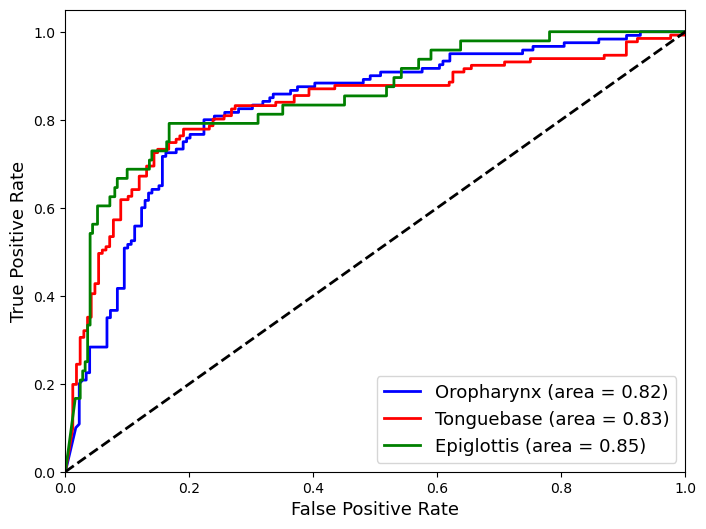

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(total_y.cpu()[:, i], total_prob.cpu()[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
test_score=roc_auc_score(total_y.cpu().argmax(axis=1),total_prob.cpu(), multi_class='ovr')
# 모든 클래스의 ROC 곡선을 그립니다.
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
class1=['Oropharynx','Tonguebase','Epiglottis']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class1[i]} (area = {roc_auc[i]:.2f})')
print(f'total AUC score= {test_score}')   
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.legend(loc="lower right",fontsize=13)
plt.show()

total f1-score= 0.7102383371433408


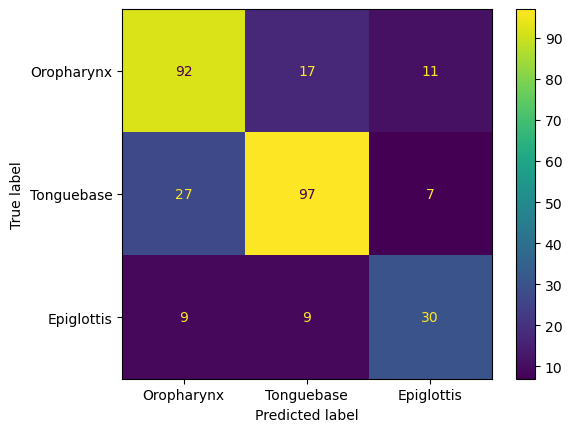

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
cm = confusion_matrix(total_y.cpu().argmax(axis=1),total_prob.cpu().argmax(axis=1))
classes = ['Oropharynx','Tonguebase','Epiglottis']

cm_display = ConfusionMatrixDisplay(cm,
                              display_labels=classes).plot()
f1 = f1_score(total_y.cpu().argmax(axis=1),total_prob.cpu().argmax(axis=1), average='macro')

print(f'total f1-score= {f1}') 